In [ ]:
# Initialize OpenSearch client
!sudo docker run -p 9200:9200 -p 9600:9600 -e "discovery.type=single-node" -e "plugins.security.disabled=true" opensearchproject/opensearch:2.11.0

In [2]:
import dotenv
dotenv.load_dotenv(override=True)

import os
import json
import yaml
import asyncio
import nest_asyncio
from lassie.core.model_loader import ModelLoader
from lassie.core.data_reader import DataReader
from lassie.core.node_transformer import PreProcessorBuilder
from lassie.core.indices import IndexLoader 
from lassie.core.retriever import RetrieverBuilder
from lassie.core.postprocessor import PostProcessorBuilder
from lassie.core.synthesizer import SynthesizerBuilder
from lassie.core.query_engine import QueryEngineBuilder
from lassie.core.evaluation.runner import RAGEvaluationRunner

nest_asyncio.apply()
HF_token = os.getenv("HF_ASSESS_TOKEN")

/home/ubuntu/lassierag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RAG pipeline
各階段皆分為Direct及Configuration-based Initialization
 1. LLM/ Embedding model loading
 2. Data loading
 3. (Optional) Node transformations setting
 4. Indexing
 5. Retriever initialization
 6. (Optional) Node postprocessors setting
 7. Synthesizer initialization
 8. Query engine initialization (若使用Configuration-based可直接執行8.)

In [3]:
# 1. LLM/ Embedding model loading
## Direct Initialization
rag_models = ModelLoader(llm_source = "huggingface", embed_model_source = "huggingface")
rag_models._llm, rag_models._llm_tokenizer = rag_models.load_llm(
    model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct",
    hf_token = os.getenv("HF_ASSESS_TOKEN"),
    context_window = 131072,
    quantization_type = "4bit",
    torch_dtype = "fp16",
    is_chat_model = True,
    model_kwargs = {},
    tokenizer_kwargs = {},
)
rag_models._embed_model, rag_models._embed_model_tokenizer = rag_models.load_embedding_model(
    model_name = "intfloat/multilingual-e5-large",
    max_length = 512,
    prefix_tokens = ("query: ", "passage: "),
)

## Configuration-based Initialization
# model_config = {
#     # "LLM": {
#     #     "source": "huggingface",
#     #     "model_name": "google/gemma-2-2b-it",
#     #     "hf_token": os.getenv("HF_ASSESS_TOKEN"),
#     #     "context_window": 8192,
#     #     "quantization_type": "4bit",
#     #     "model_kwargs": {
#     #     },
#     #     "torch_dtype": "fp16",
#     #     "is_chat_model": True,
#     # },
#     "Embedding_model": {
#         "source": "huggingface",
#         "model_name": "intfloat/multilingual-e5-large",
#         "max_length": 512,
#         "prefix_tokens": ("query:", "passage:")
#     }
# }
# rag_models = ModelLoader.from_config(config = model_config)

2024-12-24 17:36:44 - lassie.core.model_loader.hf_loader - loading the model and tokenizer of meta-llama/Meta-Llama-3.1-8B-Instruct...
2024-12-24 17:36:46 - accelerate.utils.modeling - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


2024-12-24 17:36:56 - lassie.core.model_loader.hf_loader - query:  and passage:  will be used as the query and text instruction, respectively.
2024-12-24 17:36:56 - lassie.core.model_loader.hf_loader - loading embedding model intfloat/multilingual-e5-large...
2024-12-24 17:36:56 - sentence_transformers.SentenceTransformer - Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
2024-12-24 17:37:01 - sentence_transformers.SentenceTransformer - 2 prompts are loaded, with the keys: ['query', 'text']
2024-12-24 17:37:01 - lassie.core.model_loader.hf_loader - loading the tokenizer of embedding model...


In [4]:
# 2. Data loading
## Direct Initialization
data_reader = DataReader(reader_type="simple_dir")
data_source = data_reader.load(input_dir = "/home/ubuntu/dataset/etc/source_files", required_exts = [".pdf", ".docx"])


## Configuration-based Initialization
# data_config = {
#     "reader_type": "simple_dir",
#     "input_dir": "/dataset/etc/source_files",
#     "required_exts": [".pdf", ".docx"]
# }
# data_source = DataReader.from_config(config=data_config)

2024-12-24 17:37:04 - lassie.core.data_reader.factory - Using the simple_dir reader...


In [5]:
# 3. (Optional) Node transformations setting
## Direct Initialization
preprocessor_builder = PreProcessorBuilder(loaded_models = rag_models)
preprocessor_chunker = preprocessor_builder.build_processor(processor_type="chunking", chunk_method = "sentence_window", window_size = 1)
preprocessors = [preprocessor_chunker]

## Configuration-based Initialization
# preprocess_config = {
#     "chunking":{
#         "chunk_method": "sentence_window",
#         "window_size": 1,
#     },
# }
# preprocessors = PreProcessorBuilder.from_config(loaded_models = rag_models, config=preprocess_config)

2024-12-24 17:37:08 - lassie.core.node_transformer.chunking - Initializing sentence_window splitter...


In [ ]:
# 4. Indexing
## search pipeline config
search_pipeline_config = {
  "description": "Post processor for hybrid search",
  "phase_results_processors": [
    {
      "normalization-processor": {
        "normalization": {
          "technique": "min_max"
        },
        "combination": {
          "technique": "arithmetic_mean",
          "parameters": {
            "weights": [
              0.3,
              0.7
            ]
          }
        }
      }
    }
  ]
}

## Direct Initialization
index_loader = IndexLoader(loaded_models = rag_models, database_type = "opensearch")
index = index_loader.load(
    data_source=data_source, 
    node_transformations=preprocessors, 
    host = "http://localhost:9200",
    http_auth = ("admin", "admin"),
    index_name = "etc_sentence_window_1",
    search_pipeline_name = "hybrid_search",
    search_pipeline_config = search_pipeline_config,
)

## Configuration-based Initialization
# index_config = {
#     "database_type": "opensearch",
#     "host": "http://localhost:9200",
#     "http_auth": ("admin", "admin"),
#     "index_name": "etc_sentence_window_1",
#     "search_pipeline_name": "hybrid_search",
#     "search_pipeline_config": search_pipeline_config,
# }
# index = IndexLoader.from_config(loaded_models = rag_models, config=index_config, node_transformations=preprocessors, data_source=data_source)

2024-12-24 17:37:12 - lassie.core.indices.opensearch - Pipeine <hybrid_search> exist!
2024-12-24 17:37:12 - lassie.core.indices.opensearch - Index <etc_sentence_window_1> exist! Loading index from vector database...


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

2024-12-24 17:37:13 - opensearch - GET http://localhost:9200/etc_sentence_window_1 [status:200 request:0.006s]


In [8]:
# 5. Retriever initialization
## Direct Initialization
retriever_builder = RetrieverBuilder(loaded_models = rag_models, retriever_type = "vector_index")
retriever = retriever_builder.build(index = index, similarity_top_k = 5, vector_store_query_mode = "hybrid")

## Configuration-based Initialization
# retriever_config = {
#     "retriever_type": "vector_index",
#     "similarity_top_k": 5,
#     "vector_store_query_mode": "hybrid",
# }
# retriever = RetrieverBuilder.from_config(loaded_models = rag_models, index = index, config = retriever_config)

2024-12-24 17:37:38 - lassie.core.retriever.builder - The vector_index retriever will be initialized


In [9]:
# 6. (Optional) Node postprocessors setting
## Direct Initialization
postprocessors_builder = PostProcessorBuilder(loaded_models = rag_models)
postprocessor_metadata = postprocessors_builder.build_processor(processor_type="metadata_replace", target_metadata_key = "window")
postprocessors = [postprocessor_metadata]

## Configuration-based Initialization
# postprocess_config = {
#     "metadata_replace": {
#         "target_metadata_key": "window",
#     }
# }
# postprocessors = PostProcessorBuilder.from_config(loaded_models = rag_models, config = postprocess_config)

In [10]:
# 7. Synthesizer initialization
## Direct Initialization
synthesizer_builder = SynthesizerBuilder(loaded_models = rag_models)
synthesizer = synthesizer_builder.build(response_mode = "multiqa", streaming = False)

## Configuration-based Initialization
# synthesizer_config = {
#     "response_mode": "multiqa",
#     "streaming": False
# }

# synthesizer = SynthesizerBuilder.from_config(loaded_models = rag_models, config = synthesizer_config)

In [13]:
# 8. Query engine initialization
## Direct Initialization
query_engine =  QueryEngineBuilder(retriever=retriever, synthesizer=synthesizer, postprocessors=postprocessors).build()

## Configuration-based Initialization (不需要前面所有的流程)
# with open("/lassierag/scripts/rag_config.yml", "r") as file:
#     config = yaml.safe_load(file)

# query_engine = QueryEngineBuilder.from_config(config=config)

## Evaluation Data Preparation
Evaluation batch runner 中可使用的 input 有三種：  
1. queries + query_engine
2. queries + response_objs
3. queries + contexts + responses

In [14]:
# Evaluation dataset
## Loading dataset
etc_multiqa = []
with open("/home/ubuntu/dataset/fareastern_etc_multiqa.json", "r") as f:
    for line in f:
        etc_multiqa.append(json.loads(line))

## Prepare evaluation data
#queries = [d["question"] for d in etc_multiqa] # queries in dataset
queries = [
    "請詳述異動手機號碼需要核對甚麼資料，如幾個動態資料幾個靜態資料與備註說明?", 
    "請問9/19公告有幾筆，公告內容是什麼"
]


## Options
#### Input set 1: query_engine ####
query_engine
#### Input set 2: response_objs ####
query_tasks = [query_engine.aquery(q) for q in queries]
response_objs = await asyncio.gather(*query_tasks)

#### Input set 3: context_list (list of list of str), responses (list of str) ####
# contexts_list = [[node.text for node in response_obj.source_nodes] for response_obj in response_objs]
# response = [response_obj.response for response_obj in response_objs]
contexts_list = [
    [
        "112年中秋節及國慶日連假國道交通疏運計畫QA Q：中秋節及國慶日連續假期通行費計算方式為何? A：112年中秋連續假期(112年9月29日至10月1日)及國慶日連續假期(112年10月7日至10月10日)採單一費率，小型車0.9元/公里、大型車1.12元/公里、聯結車1.35元/公里，無每日20公里優惠里程及長途折扣。 Q：中秋節及國慶日連續假期通行免收費時段從何開始? A： 2023中秋連續假期從112年9月29日至10月1日，每日0-5時國道全線暫停收費。 2023國慶連續假期從112年10月7日至10月10日，每日0-5時國道全線暫停收費。 Q：eTag用戶還有再打9折嗎? A：有的，eTag用戶若是預儲帳戶足額扣款，通行費一樣享有再9折優惠。 Q：請問我要怎麼查詢2023中秋節及國慶日連續假期的費率? A：112年端午節連續假期(112年6月22日至112年6月2)連續假期採單一費率，小型車0.9元/公里、大型車1.12元/公里、聯結車1.35元/公里，無每日20公里優惠里程及長途折扣。 有關國道疏運措施可上高公局網站查詢。https://fare.fetc.net.tw/Publish.aspx?cnid=2&p=1716",
        "公告時間：2023/9/20 (週三) 下午 06:58 公告類型：作業流程 主旨：營運場變更IP通知_P2500346俥亭左營高鐵機車 內容說明： 【營運場變更IP通知】 案場狀態 場站編號 停車場據點名稱 新IP 原IP 通知日期 開單日期 影響日期 預計完成日 類型 OPR單編號 營運中 P2500346 俥亭左營高鐵機車 114.35.116.236 220.132.29.92 2023/09/20 2023/09/20 2023/09/20 2023/09/26 車辨場 OPR-12663", "一、等級：高敏感(核資項目參考備註說明) 核資項目：2靜1動 服務內容： 1. 異動手機號碼(備註：變更原手機號碼(必核)，若無法提供時，客服可委婉引導至門市，若客訴抱怨可詢問主管個案處理。) 2. 辦理終止退費轉儲(備註：依辦理終止退費轉儲作業流程辦理，請確認欲轉儲的車號及證號。) 3. 查詢通行起訖點/路段明細 4. 會員帳號-異動 (移除車輛連結)(備註：需車主或會員帳號本人辦理，若無法核資時，請依「刪除帳號及移除車輛說明」處理) 5. 會員帳號-異動 (修改資料、刪除帳號)(備註：需會員本人辦理，需核對「會員帳號、會員證號、會員姓名、電子信箱、行動電話」，若無法核資時，請「依刪除帳號及移除車輛作業處理 」)",
        "1.1.1 工程概述 (1) 本工程之範圍位於國道 3 號樹林北上地磅站進站前主線路段建置主線篩 選式動態地磅系統，配合路側資訊可變標誌版顯示免入靜態地磅之重車 車號，由重車智慧管理軟體篩選出無超載之虞車輛得免入靜態地磅之措 施，並包含與相關系統之介接與整合工程。期望透過本系統之建置，減 特訂條款-2 緩高速公路重車之超載行為，提昇重車行車效率、強化重車管理效能。 (2) 本工程包含動態地磅設備、資訊可變標誌(CMS)、車輛偵測器(VD)、車牌 辨識系統(AVI)、閉路電視攝影機(CCTV)、傳輸系統(含伺服器)、鋼構、 土木管道等及其相關配合工作。 (3) 本工程各項設施應整合至北區「重車智慧管理系統」公版軟體整合系統 運作操控，並負責系統介接及整合測試。 ",
        "車號確認：   1. 車號＋姓名   2. 車號＋統編 ◆優先確認姓名，不知姓名時可確認統編 靜態資料：   1. 手機號碼(優先確認)   2. 車主證號   3. 車輛廠牌   4. eTag黏貼位置 ◆ 若手機號碼無法提供，可依序核資 動態資料：   1. 最近一次加值金額   2. 最近一次加值地點   3. 是否申辦自動儲值   4. 自動儲值的扣款銀行   5. 是否有申請個人專區帳號   6. 3天前是否曾行駛高速公路   7. 近一個月是否進線過客服   8. 是否有申請電子帳單的服務   9. 名下共有幾台車輛申裝eTag   10. eTag申請超過3個月、半年、一年 ",
    ],
    [
        "一、等級：高敏感(核資項目參考備註說明) 核資項目：2靜1動 服務內容： 1. 異動手機號碼(備註：變更原手機號碼(必核)，若無法提供時，客服可委婉引導至門市，若客訴抱怨可詢問主管個案處理。) 2. 辦理終止退費轉儲(備註：依辦理終止退費轉儲作業流程辦理，請確認欲轉儲的車號及證號。) 3. 查詢通行起訖點/路段明細 4. 會員帳號-異動 (移除車輛連結)(備註：需車主或會員帳號本人辦理，若無法核資時，請依「刪除帳號及移除車輛說明」處理) 5. 會員帳號-異動 (修改資料、刪除帳號)(備註：需會員本人辦理，需核對「會員帳號、會員證號、會員姓名、電子信箱、行動電話」，若無法核資時，請「依刪除帳號及移除車輛作業處理 」)", 
        "公告日期：2023/9/19 (週二) 下午 10:13 公告類型：系統維護與更版 主旨：2023/09/18 遠創服務暫停事件通報單 內容說明： 有關BOM通報2023/09/19(二) 22:00 ~ 2023/09/20(三) 08:00 ETC資料庫主機升級作業，相關影響及因應措施整理如下，感謝。 影響服務：   • 減碳車幣兌換儲值金   • 數位帳戶自動儲   • 街口支付單次儲值   • OPEN POINT兌換儲值金   • 全家會員點數兌換儲值金   • HAPPY GO兌換儲值金   • 餘額查詢服務  公告日期：2023/9/19 (週二) 下午 10:13 公告類型：系統維護與更版 主旨：2023/09/18 遠創服務暫停事件通報單 內容說明： 有關BOM通報2023/09/19(二) 22:00 ~ 2023/09/20(三) 08:00 ETC資料庫主機升級作業，相關影響及因應措施整理如下，感謝。 影響服務：   • 減碳車幣兌換儲值金   • 數位帳戶自動儲   • 街口支付單次儲值   • OPEN POINT兌換儲值金   • 全家會員點數兌換儲值金   • HAPPY GO兌換儲值金   • 餘額查詢服務  因應措施： uTagGo Web-首頁公告：依上版日~9/20(三)08:00露出 【服務公告】 9/19(二)22:00~9/20(三)08:00因系統維護影響uTagGo App 下列服務無法使用，造成不便，敬請見諒 uTagGo App-公告頁：9/19(二)22:00~9/20(三)08:00露出 【服務公告】 9/19(二)22:00~9/20(三)08:00因系統維護影響uTagGo App 下列服務無法使用，造成不便，敬請見諒 uTagGo App-通知中心：上版日~10/18(三)00:00止露出 【服務公告】 9/19(二)22:00~9/20(三)08:00因系統維護影響uTagGo App 下列服務無法使用，造成不便，敬請見諒 影響服務：   • 減碳車幣兌換儲值金、數位帳戶自動儲、街口支付單次儲值、OPEN POINT兌換儲值金、全家會員點數兌換儲值金、HAPPY GO兌換儲值金、餘額查詢服務;", 
        "公告日期：2023/9/14 (週四) 下午 11:58 公告類型：作業流程 主旨：嘟嘟房車辨異常好發案場「開啟」180天會員進出場通知發送邏輯 內容說明： 針對嘟嘟房車辨異常好發案場，將於9/15恢復180天會員通知邏輯， 故會員進出場通知發送邏輯資訊更新如附件檔案， eTag停車扣繳合作停車場資訊(停車場大表) 內之「會員進出場通知發送邏輯」頁籤，將於下一次公告檔案時同步更新。 車辨異常好發案場如下： 1.    P6901004嘟嘟房建國高架北站 2. P9600031嘟嘟房宏匯瑞光 3. P9600091嘟嘟房松山八德 4. P9600075嘟嘟房汐止茄苳 5.P9600074嘟嘟房汐止金龍", 
        "112年中秋節及國慶日連假國道交通疏運計畫QA Q：中秋節及國慶日連續假期通行費計算方式為何? A：112年中秋連續假期(112年9月29日至10月1日)及國慶日連續假期(112年10月7日至10月10日)採單一費率，小型車0.9元/公里、大型車1.12元/公里、聯結車1.35元/公里，無每日20公里優惠里程及長途折扣。 Q：中秋節及國慶日連續假期通行免收費時段從何開始? A： 2023中秋連續假期從112年9月29日至10月1日，每日0-5時國道全線暫停收費。 2023國慶連續假期從112年10月7日至10月10日，每日0-5時國道全線暫停收費。 Q：eTag用戶還有再打9折嗎? A：有的，eTag用戶若是預儲帳戶足額扣款，通行費一樣享有再9折優惠。 Q：請問我要怎麼查詢2023中秋節及國慶日連續假期的費率? A：112年端午節連續假期(112年6月22日至112年6月2)連續假期採單一費率，小型車0.9元/公里、大型車1.12元/公里、聯結車1.35元/公里，無每日20公里優惠里程及長途折扣。 有關國道疏運措施可上高公局網站查詢。https://fare.fetc.net.tw/Publish.aspx?cnid=2&p=1716", 
        "廠商須於開工次日起 45 日曆天完成設備(協力商)採購訂單 廠商應於試運轉前 30 日曆天提出整體功能試運轉計畫書，提報工程司核定後，始得辦理試運轉作業。 於整體功能試運轉檢測開始後 20 日曆天內擬定保固期間定期保養工作計畫，包括各系統之定期保養維護預定時間表 (所規定每半年及每年週 期之維護及檢查項目在契約結束前最後一個月，須要執行一次檢查)，提 送甲方核可後實施，使保固期間之定期保養維護工作能按照一定之日程進行。 廠商須於本工程可靠性測試完成後 14 個日曆天內將其保固養護小組組織架構、任務編組、權責分工、人員名單等詳細內容資料，提送甲方核可。"
    ],
]
responses = [
    "異動手機號碼需要核對的資料包括靜態資料和動態資料。靜態資料需要核對手機號碼（優先確認）、車主證號、車輛廠牌及eTag黏貼位置[3][5]。動態資料則包括最近一次加值金額、最近一次加值地點、是否申辦自動儲值、自動儲值的扣款銀行、是否有申請個人專區帳號、3天前是否曾行駛高速公路、近一個月是否進線過客服、是否有申請電子帳單的服務、名下共有幾台車輛申裝eTag、以及eTag申請超過3個月、半年、一年[5]。\n\n備註說明中提到，若無法提供原手機號碼，客服可委婉引導至門市辦理，若客訴抱怨則可詢問主管進行個案處理[3]。", 
    "2023年9月19日的公告有一筆，內容是關於ETC資料庫主機升級作業的系統維護與更版通知。該公告指出，2023年9月19日22:00至2023年9月20日08:00期間，因系統維護，uTagGo App的多項服務將暫停，包括減碳車幣兌換儲值金、數位帳戶自動儲值、街口支付單次儲值、OPEN POINT兌換儲值金、全家會員點數兌換儲值金、HAPPY GO兌換儲值金及餘額查詢服務[2]。",
]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 71.60it/s]

2024-12-24 17:39:34 - opensearch - POST http://localhost:9200/etc_sentence_window_1/_search?search_pipeline=hybrid_search [status:200 request:0.056s]



/home/ubuntu/lassierag/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ubuntu/lassierag/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


2024-12-24 17:39:49 - opensearch - POST http://localhost:9200/etc_sentence_window_1/_search?search_pipeline=hybrid_search [status:200 request:15.172s]


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


## Evaluation Runner


In [15]:
# Initialize evaluation pipeline runner
eval_pipeline = RAGEvaluationRunner(num_worker = 4)

2024-12-24 17:40:16 - lassie.core.evaluation.runner - Evaluators used in this pipeline: ['context_relevance', 'faithfulness', 'response_relevance']


In [16]:
# RAG 流程中的一些設定 (for mlflow)
RAG_log = {
    "parameter_log": {
        "RAG_embed_model": "intfloat/multilingual-e5-small",
        "RAG_retrieval_method": "hybrid",
        "RAG_preprocess_chunking": "sentence_window",
        "RAG_preprocess_chunking_sentence_window": {"window_size": 1},
        "RAG_model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    },
    "tag_log": {
        "dataset": "etc_test",
        "dataset_num": 2,
        "use_chat_template": True,
        "has_finetuned": False,
    },
}

2024-10-29 14:59:00 - lassie.modules.evaluation.runner - queries, contexts, and responses will be used in the evaluation


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


2024-10-29 14:59:11 - botocore.credentials - Found credentials in environment variables.
2024-10-29 14:59:14 - lassie.utils - Your experiment record at:
2024-10-29 14:59:14 - lassie.utils - https://mlflow.phate.dev/#/experiments/192/runs/800665f372c140639c91e0a4b8b243ab


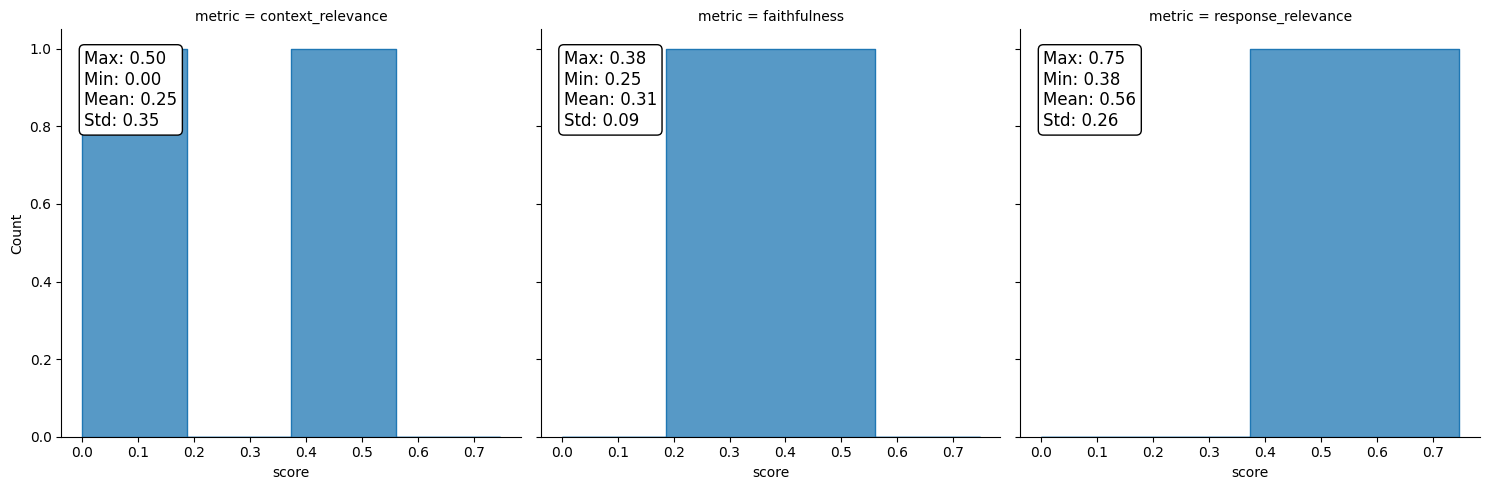

In [9]:
# Run Evaluation pipeline
rag_performance, rag_eval_by_metric = eval_pipeline.run(
    queries = queries,
    #### input set 1 #### (Easer!)
    #query_engine = query_engine,
    #### input set 2 ####
    #response_objs= response_objs,
    #### input set 3 #### (Faster!)
    responses = responses,
    contexts_list = contexts_list,
    mlflow_run_name = "llama3.1_etc_test",
    mlflow_logs = RAG_log,
    output_dir="/home/ubuntu/RAG_Evaluation/output_test"
)

In [10]:
rag_performance

,query,contexts,response,context_relevance,faithfulness,response_relevance
0,請詳述異動手機號碼需要核對甚麼資料，如幾個動態資料幾個靜態資料與備註說明?,[1] 一、等級：高敏感(核資項目參考備註說明)\n\n核資項目：2靜1動\n\n服務內容：...,根據提供的文件，異動手機號碼需要核對的資料如下：\n\n動態資料：[14][23][24]指...,0.5,0.375,0.747
1,請問9/19公告有幾筆，公告內容是什麼,[1] (1) 「整體施工（工作）計畫」報工務段（中心）。\n\n(2)核定「分項施工（工作...,根據提供的文件，9/19公告有兩筆，內容如下：\n\n1. 2.14日內完成初審，並將審查意...,0.0,0.250,0.380


In [11]:
rag_eval_by_metric

{'context_relevance': [{'query': '請詳述異動手機號碼需要核對甚麼資料，如幾個動態資料幾個靜態資料與備註說明?',
   'contexts': ['一、等級：高敏感(核資項目參考備註說明)\n\n核資項目：2靜1動\n\n服務內容：\n\n異動手機號碼(備註：變更原手機號碼(必核)，若無法提供時，客服可委婉引導至門市，若客訴抱怨可詢問主管個案處理。)\n\n辦理終止退費轉儲(備註：依辦理終止退費轉儲作業流程辦理，請確認欲轉儲的車號及證號。)\n\n查詢通行起訖點/路段明細\n\n會員帳號-異動 (移除車輛連結)(備註：需車主或會員帳號本人辦理，若無法核資時，請依「刪除帳號及移除車輛說明」處理)\n\n會員帳號-異動 (修改資料、刪除帳號)(備註：需會員本人辦理，需核對「會員帳號、會員證號、會員姓名、電子信箱、行動電話」，若無法核資時，請「依刪除帳號及移除車輛作業處理 」)',
    '一、等級：高敏感(核資項目參考備註說明)\n\n核資項目：2靜1動\n\n服務內容：\n\n異動手機號碼(備註：變更原手機號碼(必核)，若無法提供時，客服可委婉引導至門市，若客訴抱怨可詢問主管個案處理。)\n\n辦理終止退費轉儲(備註：依辦理終止退費轉儲作業流程辦理，請確認欲轉儲的車號及證號。)\n\n查詢通行起訖點/路段明細\n\n會員帳號-異動 (移除車輛連結)(備註：需車主或會員帳號本人辦理，若無法核資時，請依「刪除帳號及移除車輛說明」處理)\n\n會員帳號-異動 (修改資料、刪除帳號)(備註：需會員本人辦理，需核對「會員帳號、會員證號、會員姓名、電子信箱、行動電話」，若無法核資時，請「依刪除帳號及移除車輛作業處理 」)',
    '一、等級：高敏感(核資項目參考備註說明)\n\n核資項目：2靜1動\n\n服務內容：\n\n異動手機號碼(備註：變更原手機號碼(必核)，若無法提供時，客服可委婉引導至門市，若客訴抱怨可詢問主管個案處理。)\n\n辦理終止退費轉儲(備註：依辦理終止退費轉儲作業流程辦理，請確認欲轉儲的車號及證號。)\n\n查詢通行起訖點/路段明細\n\n會員帳號-異動 (移除車輛連結)(備註：需車主或會員帳號本人辦理，若無法核資時，請依「刪除帳號及移除車輛說明」處理)\n\n會員帳號-異動 (修改資料、刪除帳號)(備註：需會員本人辦